In [2]:
import pandas as pd
import numpy as np
import random as rng
import time

# Supporting
from schedule import Schedule
from paintshop import PaintShop
from move import Move

from heuristics_constructive import ConstructiveHeuristic
from heuristics_improvement import Basic, Taboo

: 


move: (1, 2) => (0, 1)
    |  0   1   2   3   4   5   6   7   8   9  10  11  | 1487.69 ✘
M1: |  0   6   1  11   7  15  19  21  23  26          | 378.00 (25%)
M2: | 12  21   2   4   9  16  18  17  24  27   3  29  | 860.80 (58%)
M3: | 10   5  13   8  14  25  22  28                  | 248.89 (17%)

move: (1, 11) => (1, 9)
    |  0   1   2   3   4   5   6   7   8   9  10  11  | 1031.89 ✘
M1: |  0   6   1  11   7  15  19  21  23  26          | 378.00 (37%)
M2: | 12  21   2   4   9  16  18  17  24  29  27  29  | 405.00 (39%)
M3: | 10   5  13   8  14  25  22  28                  | 248.89 (24%)

move: (1, 1) => (0, 5)
    |  0   1   2   3   4   5   6   7   8   9  10  | 767.59 ✘
M1: |  0   6   1  11   7  21  15  19  21  23  26  | 463.50 (60%)
M2: | 12   2   4   9  16  18  17  24  29  27  29  | 55.20  (7%)
M3: | 10   5  13   8  14  25  22  28              | 248.89 (32%)

move: (0, 5) => (1, 5)
    |  0   1   2   3   4   5   6   7   8   9  10  11  | 759.49 ✘
M1: |  0   6   1  11   7  15  19  21 

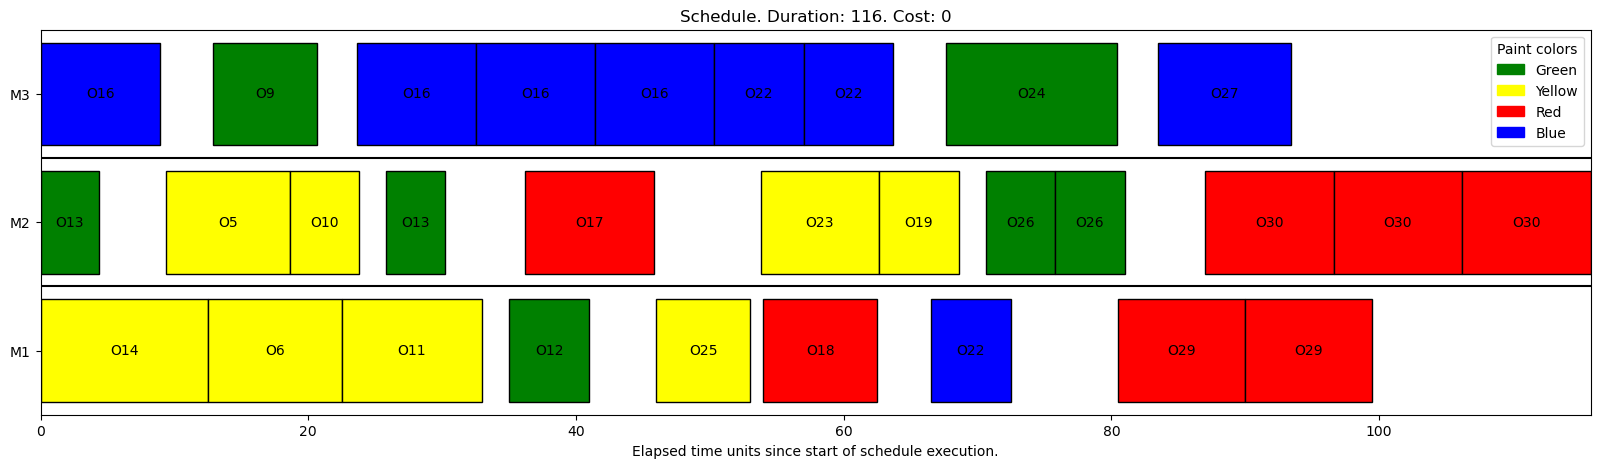

In [ ]:
from heuristics_constructive import ConstructiveHeuristics
from moveSelectionStrategy import MoveSelectionStrategies


a = ConstructiveHeuristics.random.get_schedule()
print(a)
for i in range(100):
    move, b = MoveSelectionStrategies.random.try_get_move(a, lambda s: s.cost < a.cost)
    if move is None:
        break
    a = b
    print()
    print(move)
    print(a)
print()
print(a)
a.plot()

In [ ]:
from heuristics_constructive import ConstructiveHeuristics
from moveSelectionStrategy import MoveSelectionStrategies

heuristic = Basic(MoveSelectionStrategies.random)
s = heuristic.run(ConstructiveHeuristics.random.get_schedule())

In [ ]:
s.best.plot()

# Settings

In [5]:
SEED = 420

# Setup

In [6]:
rng.seed(SEED)
PS = PaintShop()

# Classes

Metaheuristics:
- Multistart:  Improving multiple starts and take the best local optimum
- Taboo Search: Reverse steps are forbidden (taboo-list). Tabu moves are removed from the list after a number of moves. Stop at a certain number of iterations OR when all available moves are taboo. Keep track of incumbent solution.
- Simulated Annealing: Temperature & cooling schedule. Allways accepts improving moves. Non-improving moves with probablity based on the obj. improvement and temperature. Randomly choose a move, compute the gain. If it improves, accept, otherwise accept with probability e^(delta_obj / q). Update incumbent solution. Reduce temperature q. See graph in slides.
- Genetic algorithms: Many different ideas. Population of solutions.
   - Start with a number of random solutions.
   - Create new solutions by combining pairs.
   - Mutations sometimes.
   - Select survivors (elite).



# Solution

In [ ]:
print(Heuristics.Contructive.greedy.get_schedule())

In [ ]:
print(Heuristics.Contructive.random.get_schedule())

In [9]:
def run_to_termination(constructive_heuristic: ConstructiveHeuristic, improvement_heuristic: ImprovementStrategy, verbosity = 1) -> tuple[Schedule, int, float]:
    """Run the specified improvement heuristic to termination, starting with a solution generated by the specified constructive heuristic.

    Args:
        constructive_heuristic (ConstructiveHeuristic): The constructive heuristic.
        improvement_heuristic (ImprovementHeuristic): The improvement heuristic.
        verbose (bool, optional): The degree to which progress is displayed. 0, 1 or 2. Defaults to 1.

    Returns:
        tuple[Schedule, int, float]: A tuple containing the resultant solution, the amount of moves applied and the time it took to run, respectively.
    """
    
    # Construct feasible solution
    incumbent_solution = constructive_heuristic.get_schedule()
    
    # Print progress if verbose
    if verbosity >= 1:
        print(f"Initial solution:\n{incumbent_solution}")
    
    # Keep track of amount of moves and starting time
    move_count = 0
    t0 = time.time()
    
    # Loop until local optimum found
    while True:
        
        # Get improvement
        (move, incumbent_solution) = improvement_heuristic.get_improvement(incumbent_solution)
        
        # Check if optimal
        if move is None:
            break
        
        # Record the fact that a move was made.
        move_count += 1
        
        # Print move if verbose
        if verbosity >= 1:
            print(f"\n{move_count}: {move}")
            if verbosity >= 2:
                print(f"{incumbent_solution}")
    
    # Determine time spent
    t_delta = time.time() - t0
    
    # Print results if verbose
    if verbosity >= 1:
        print(f"\nHeuristic terminated after {move_count} moves ({t_delta:.1f}s):\n{incumbent_solution}")
    
    # Return results
    return (incumbent_solution, move_count, t_delta)

In [ ]:
Heuristics.Contructive.random.get_schedule().draw()

In [ ]:
(solution, move_count, t_delta) = run_to_termination(Heuristics.Contructive.greedy, Heuristics.Improvement.first, verbosity=2)

print(t_delta)
solution.draw()

In [12]:
import math
import time

def heuristic_improvement_comparison_multistart(n_starts, constructive_heuristic: ConstructiveHeuristic, improvement_heuristic: ImprovementStrategy) -> list[dict]:
    
    # Generate n_starts random feasible solutions, initialize a list of dictionaries to keep track of things.
    starting_schedules: list[Schedule] = [constructive_heuristic.get_schedule() for _ in range(n_starts)]
    runs_data = [
        {
            "incumbent": schedule,
            "imcumbent_cost": schedule.get_cost(),
            "history": [],
            "done": False,
        } for schedule in starting_schedules
    ]
    
    print(f"Generated {n_starts} schedules.")
    print(f"Starting improvement heuristic...")
    
    # Heuristic loop
    iteration_count = 0
    while any([(not run["done"]) for run in runs_data]):
        
        iteration_count += 1
        
        # For each run
        for run_index in range(n_starts):
                        
            # If the run is done, do nothing
            if runs_data[run_index]["done"]:
                continue
            
            t0 = time.time()
            
            # Get the first improving feasible move
            move: Move
            moved_schedule: Schedule
            move, moved_schedule = improvement_heuristic.get_improvement(runs_data[run_index]["incumbent"])
            
            # If terminated, set done and continue
            if move is None:
                runs_data[run_index]["done"] = True
                continue
                        
            # Update schedule, add history entry
            runs_data[run_index]["incumbent"] = moved_schedule
            # Create history entry
            runs_data[run_index]["history"] += [{
                "processing_time": time.time() - t0,
                "move": move,
                "cost": moved_schedule.get_cost()
            }]
        
        
        # Print progress
        cur_penalties = [data['history'][-1]["cost"] for data in runs_data]
        cur_times = [data['history'][-1]["processing_time"] for data in runs_data]
        print(f"{iteration_count}: {sum([1 for run in runs_data if not run['done']])}/{n_starts} | {np.mean(cur_penalties):.0f} ± {np.std(cur_penalties):.0f} ({sum(cur_times):.2f}s)")
    
    # Print completion
    print(f'No improving moves found.')
    return (iteration_count, runs_data)




In [13]:
def discrete_improvement_run(constructive_heuristic: ConstructiveHeuristic, improvement_strategy: ImprovementStrategy):
    
    start: Schedule = constructive_heuristic.get_schedule()
    data = {
        "incumbent": start,
        "iteration_count": 0,
        "history": [],
    }
    
    
    iteration_count = 0
    while True:
        
        
        t0 = time.time()
        
        # Get the first improving feasible move
        move: Move
        moved_schedule: Schedule
        move, moved_schedule = improvement_strategy.get_improvement(data["incumbent"], Move.get_moves(data["incumbent"]))

        if (move is None):
            break
        
        # Create history entry
        data["history"] += [{
            "processing_time": time.time() - t0,
            "move": move,
            "cost": moved_schedule.get_cost()
        }]
        
        #
        iteration_count += 1
        
        # Update schedule, add history entry
        data["incumbent"] = moved_schedule
        
    data["iteration_count"] = iteration_count
    
    return data

In [14]:
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
def plot_multistart(runs, constructive: ConstructiveHeuristic, improvement: ImprovementStrategy):
    
    iter_count = max([run["iteration_count"] for run in runs])
    
    iterations = range(iter_count - 1)
    
    iteration_costs = [
        [
            run["history"][i]["cost"] for run in runs if i < len(run["history"])
        ] for i in iterations
    ]
    
    penalty_means = np.array([
        np.mean([ic]) for ic in iteration_costs
    ])
    penalty_stds = np.array([
        np.std([ic]) for ic in iteration_costs
    ])

    best_run_index = sorted(range(len(runs)), key = lambda ri: runs[ri]["history"][-1]["cost"])[0]
    best_run = runs[best_run_index]
    
    # Create figure grid
    trackplot: Axes
    spreadplot: Axes
    fig, (trackplot, spreadplot) = plt.subplots(1, 2, figsize = (20,6))
    fig.suptitle(f"{improvement.name_display}: {len(runs)}x {constructive.name_display} multistart")
    
    # Trackplot
    best_plot_trackplot: Line2D
    run_trackplot: Line2D
    for ri, run in enumerate(runs):
        if ri != best_run_index:
            run_trackplot = trackplot.plot(
                range(len(run["history"])), 
                [entry['cost'] for entry in run["history"]],
                # linewidth = 3 if (ri == best_run_index) else 1
                linewidth = 2,
                alpha = .2,
            )[0]
            trackplot.plot(
                [len(run["history"]) - 1], 
                [run["history"][-1]["cost"]],
                # linewidth = 3 if (ri == best_run_index) else 1
                markersize = 3,
                marker = "o",
                alpha = 1,
                color = run_trackplot.get_color()
            )[0]
            
    # Best run
    best_plot_trackplot = trackplot.plot(
        range(len(best_run["history"])), 
        [entry['cost'] for entry in best_run["history"]],
        # linewidth = 3 if (ri == best_run_index) else 1
        linewidth = 3,
        alpha = 1,
        label = "Best run",
        color = 'black'
    )[0]
    trackplot.plot(
        [len(best_run["history"]) - 1], 
        [best_run["history"][-1]["cost"]],
        # linewidth = 3 if (ri == best_run_index) else 1
        markersize = 3,
        marker = "o",
        alpha = 1,
        color = best_plot_trackplot.get_color()
    )[0]
            
            
    trackplot.set_title("Runs")
    trackplot.set_yscale('log')
    y_max = max([run['history'][0]['cost'] for run in runs])
    trackplot.set_ylim(0, y_max)
    trackplot.set_xlim(0, None)
    trackplot.set_ylabel("Penalty (log)")
    trackplot.set_xlabel("Iterations")
    trackplot.legend()
    # trackplot.grid(True, 'minor')
    
    # Spreadplot
    spreadplot.fill_between(iterations, penalty_means - penalty_stds, penalty_means + penalty_stds, alpha = 0.3, label = "μ±σ")
    spreadplot.plot(iterations, penalty_means, label='μ')
    spreadplot.plot(
        range(len(runs[best_run_index]["history"])), 
        [entry['cost'] for entry in runs[best_run_index]["history"]], 
        label = f"best run\n({runs[best_run_index]['history'][-1]['cost']:.2f})", 
        color = best_plot_trackplot.get_color(),
        linewidth = 3,
    )
    
    # Best
    spreadplot.plot(
        [len(runs[best_run_index]["history"]) - 1], 
        [runs[best_run_index]["history"][-1]["cost"]],
        # linewidth = 3 if (ri == best_run_index) else 1
        markersize = 6,
        marker = "o",
        alpha = 1,
        color = best_plot_trackplot.get_color()
    )
    
    # Done
    spreadplot.plot(
        iterations, 
        [sum([y_max/len(runs) for run in runs if run["iteration_count"] <= i]) for i in iterations],
        # linewidth = 3 if (ri == best_run_index) else 1
        markersize = 6,
        alpha = 1,
        label = "% terminated"
    )
    
    # spreadplot.set_title(f"First improvement: {len(runs)}x random multistart")
    spreadplot.legend()
    spreadplot.set_yscale('log')
    spreadplot.set_ylim(0, max([run['history'][0]['cost'] for run in runs]))
    spreadplot.set_ylabel("Penalty (log)")
    spreadplot.set_xlabel("Iterations")
    # spreadplot.grid(True, 'minor')
    
    plt.show()
    

In [15]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    print(f"Saved: '{filename}'")

In [ ]:
n_runs = 200
constructive = Heuristics.Contructive.random
# improvement = Heuristics.Improvement.first
improvement = Heuristics.Improvement.best
# (iter_count, runs) = heuristic_improvement_comparison_multistart(n_runs, constructive, improvement)

import uuid
import os

cache_folder = f"multistart_{constructive.name}_{improvement.name}"

for ri in range(n_runs):
    
    run_data = discrete_improvement_run(constructive, improvement)
    
    print(f"Run terminated at {run_data['history'][-1]['cost']:.0f} after {run_data['iteration_count']} iterations. ({sum([data['processing_time'] for data in run_data['history']]):.1f}s)")
    
    if not os.path.exists(cache_folder):
        os.mkdir(cache_folder)
    
    # Save with random uuid
    save_object(run_data, os.path.join(cache_folder, f'{uuid.uuid4()}.pkl'))

In [ ]:
runs = []
for run_path in os.listdir(cache_folder):
    with open(os.path.join(cache_folder, run_path),'rb') as file:
        runs += [pickle.load(file)]
        
plot_multistart(runs, constructive, improvement)

In [ ]:
constructive = Heuristics.Contructive.random
improvement = Heuristics.Improvement.first
cache_folder = f"multistart_{constructive.name}_{improvement.name}"

# Load runs
runs = []
for run_path in os.listdir(cache_folder):
    with open(os.path.join(cache_folder, run_path),'rb') as file:
        runs += [pickle.load(file)]
        
# Plot multistart
plot_multistart(runs, constructive, improvement)

In [ ]:
best_run_index = sorted(range(len(runs)), key = lambda ri: runs[ri]["history"][-1]["cost"])[0]
best_run = runs[best_run_index]
best_run_schedule: Schedule = best_run["incumbent"]
print(best_run_schedule)
best_run_schedule.draw()

In [ ]:
# import matplotlib.animation as animation

# def plot_multistart_animation(n_runs: int, constructive_heuristic: Callable[[], Schedule], improvement_heuristic: Callable[[Schedule], Move]) -> None:
    
#     # Initialize plot
#     plt.ion()
#     fig, ax = plt.subplots()

#     # List of runs data
#     runs = [{
#         "hist_schedule": [schedule],
#         "hist_penalty": [cost],
#         "hist_move": [],
#         "done": False,
#         "line": plt.plot([0], [cost], lw = 2)[0]
#     } for schedule, cost in 
#         [
#             (schedule, schedule.get_cost()) for schedule in 
#             [constructive_heuristic() for _ in range(n_runs)]
#         ]
#     ]
    
        
    
#     plt.ylim(0, max([run["hist_penalty"][-1] for run in runs]))
#     plt.pause(1)
#     # plt.autoscale(True)
#     # plt.show()
    
#     print(f"Generated {n_runs} initial schedules.")
#     print(f"Starting improvement heuristic.")
    
#     # Heuristic loop, do until all runs are done
#     iter_count = 0
#     while any([not run["done"] for run in runs]):
    
        
#         iter_count += 1
#         print(f"Iteration {iter_count}:")
        
#         # For each run
#         for ri in range(n_runs):
            
#             # If the run is done: skip
#             if runs[ri]["done"]:
#                 continue
            
#             # Get the move according to the specified improvement heuristic
#             move = improvement_heuristic(runs[ri]["hist_schedule"][-1])
            
                        
#             # Check if no improving move was found
#             if move is None:
#                 runs[ri]["done"] = True
#                 print(f"Run {ri}: No improvement found.")
#                 continue
    
#             # Apply move, add to history
#             moved_schedule = move.get_moved(runs[ri]["hist_schedule"][-1])
#             moved_cost = moved_schedule.get_cost()
#             runs[ri]["hist_schedule"] += [moved_schedule]
#             runs[ri]["hist_penalty"] += [moved_cost]
            
#             print(f"Run {ri}: {moved_cost:.0f} ({move})")
            
#             # Update plot
            
#             # removing the older graph
#             runs[ri]["line"].remove()
#             runs[ri]["line"] = plt.plot(range(len(runs[ri]["hist_penalty"])), runs[ri]["hist_penalty"])[0]
            
#             plt.pause(0.25)
            
#             # runs[ri]["line"].set_xdata(np.array(range(len(runs[ri]["hist_penalty"]))))
#             # runs[ri]["line"].set_ydata(np.array(runs[ri]["hist_penalty"]))
            

# Code Validation

In [12]:
import itertools as iter

### Move-set redundancy
Ensuring that no two moves produce the same moved schedules.

In [ ]:
# Generate and display a random schedule
s = heuristic_constructive_random()
print(s)

# Generate all possible moves and print the amount
moves: list[Move] = Move.get_moves(s)
print(f'\nAmount of moves: {len(moves)}')

# Generate the moved schedules for all the moves
moved_schedules = [move.get_moved(s) for move in moves]
print(f"\nMoves that do nothing: {sum([(s == moved_s) for moved_s in moved_schedules])}")

# Display the amount of unique moved schedules
print(f'\nUnique schedules after moves: {len(set(moved_schedules))}')

# Create a dictionary of moves by the hash-code of the moved schedule that they produce
by_hash = {}
for move in moves:
    
    # Get moved schedule
    moved = move.get_moved(s)
    
    # Get hash-code
    hash_code = hash(moved)
    
    # Add move if hash-code exists in dict, else: add it.
    if hash_code in by_hash.keys():
        by_hash[hash_code]["moves"] += [move]
    else:
        by_hash[hash_code] = {
            "moves": [move],
            "schedule": moved
        }
        
# Display all the non-unique moved schedules along with their moves
for hash_code, data in [(hash_code, data) for hash_code, data in by_hash.items() if len(data["moves"]) > 1]:
    print()
    print(data["schedule"])
    for move in data["moves"]:
        print(move)